# START

In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
import string
import nltk
import emoji
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from autocorrect import Speller
import swifter
import mlflow
import mlflow.sklearn
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

/home/kamel/Openclassroom_projets/P7/.p7venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-12-02 11:14:58.831387: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-02 11:14:58.943498: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-02 11:15:00.370109: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may s

In [3]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
print("Version TF :", tf.__version__)
print("CUDA dispo dans la build :", tf.test.is_built_with_cuda())
print("GPUs vus par TensorFlow :", tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Version TF : 2.20.0
CUDA dispo dans la build : True
GPUs vus par TensorFlow : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# DATA READING

In [4]:
# Load and preprocess data
df = pd.read_csv("../../sentiment140/training.1600000.processed.noemoticon.csv",
                 encoding='latin-1',
                 header=None,
                 names=['sentiment','id','date','query','user','tweet'])

df.head()

,sentiment,id,date,query,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
df = df[['sentiment','tweet']]
df.head()

,sentiment,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [6]:
# Stratified sampling to have tweets of the two sentiments
df_negatifs = df[df['sentiment'] == 0].sample(8000, random_state=42)
df_positifs = df[df['sentiment'] == 4].sample(8000, random_state=42)

# So we get a sample of 10% of the original dataset
df = pd.concat([df_negatifs, df_positifs]).reset_index(drop=True)
df['sentiment'] = df['sentiment'].replace(4, 1)
df.head()

,sentiment,tweet
0,0,@xnausikaax oh no! where did u order from? tha...
1,0,A great hard training weekend is over. a coup...
2,0,"Right, off to work Only 5 hours to go until I..."
3,0,I am craving for japanese food
4,0,Jean Michel Jarre concert tomorrow gotta work...


# CLEANING TEXT

## Preprocessing

✅ Preprocessing steps(preparing for TF-IDF + Logistic Regression)

Compared to the preprocessing of tweets made during the application of logistic regression, the steps written in red have been removed, and the steps in green are repeated or added for this time.


<span style="color:green"></span>

<span style="color:green">- Lowercase</span>

<span style="color:red">- Expand contractions</span>

<span style="color:green">- Convert emoticons → words</span>

<span style="color:green">- Convert emojis → words</span>

<span style="color:green">- Remove URLs, mentions, hashtags</span>

<span style="color:red">- special chars, and punctuation</span>

<span style="color:green">- Tokenize</span>

<span style="color:red">- Remove stopwords</span>

<span style="color:red">- Lemmatize</span>

<span style="color:red">- Join tokens back</span>

In [7]:
import re
from typing import List, Tuple, Optional

try:
    # optional but nice: converts emojis → words like ":smiling_face:" -> "smiling face"
    from emoji import demojize
    _HAS_EMOJI = True
except Exception:
    _HAS_EMOJI = False

# ---------- light, meaning-preserving normalization ----------

_EMOTICONS = {
    r":-\)|:\)|=\)|:\]": "smile",
    r":-D|:D|=D": "laugh",
    r":-\(|:\(|=\(|:\[": "sad",
    r":'\(|:'-\(": "cry",
    r";-\)|;\)": "wink",
    r":-P|:P": "playful",
    r":/|:-/": "skeptical",
    r":\*": "kiss",
    r">:\(|>:-\(": "angry",
    r"XD|xD": "laugh",
}

_EMOTICON_REGEXES = [(re.compile(p), w) for p, w in _EMOTICONS.items()]

_URL_RE   = re.compile(r"(https?://\S+|www\.\S+)")
_USER_RE  = re.compile(r"@\w+")
_NUM_RE   = re.compile(r"\b\d+\b")
# keep ! and ?; drop most other punctuation later if you want (we keep them)
# Hashtags: keep the hashtag and add its content as a separate token
_HASHTAG_RE = re.compile(r"#(\w+)")
# compress character repetitions to max 3 (so "sooooo" -> "sooo")
_REPEAT_RE  = re.compile(r"(.)\1{3,}")

def _emoticons_to_words(text: str) -> str:
    for rgx, word in _EMOTICON_REGEXES:
        text = rgx.sub(f" {word} ", text)
    return text

def _emojis_to_words(text: str) -> str:
    if not _HAS_EMOJI:
        return text
    text = demojize(text, language="en")
    # demojize yields ":grinning_face_with_big_eyes:" → turn to words
    text = re.sub(r":([a-zA-Z0-9_]+):", lambda m: " " + m.group(1).replace("_", " ") + " ", text)
    return text

def normalize_tweet(t: str) -> str:
    t = t.strip().lower()
    t = _URL_RE.sub(" <URL> ", t)
    t = _USER_RE.sub(" <USER> ", t)
    t = _NUM_RE.sub(" <NUM> ", t)
    t = _emoticons_to_words(t)
    t = _emojis_to_words(t)
    # keep hashtag token, also add its de-hashed word
    t = _HASHTAG_RE.sub(lambda m: f" #{m.group(1)} {m.group(1)} ", t)
    # compress extreme elongations but keep emphasis
    t = _REPEAT_RE.sub(r"\1\1\1", t)
    # normalize whitespace
    t = re.sub(r"\s+", " ", t).strip()
    return t

# ---------- training-time helpers ----------
def build_tokenizer(train_texts: List[str],
                    vocab_size: int = 20000,
                    oov_token: str = "<OOV>") -> Tokenizer:
    """Fit a Keras tokenizer on *normalized* training texts."""
    norm_train = [normalize_tweet(t) for t in train_texts]
    tok = Tokenizer(num_words=vocab_size, oov_token=oov_token, filters="")  # keep punctuation like ! ?
    tok.fit_on_texts(norm_train)
    return tok

def preprocess_train(train_texts: List[str],
                     tokenizer: Tokenizer,
                     max_len: int = 50) -> Tuple[List[List[int]], List[List[int]]]:
    """Return padded sequences and (optional) attention masks for training."""
    norm = [normalize_tweet(t) for t in train_texts]
    seqs = tokenizer.texts_to_sequences(norm)
    padded = pad_sequences(seqs, maxlen=max_len, padding="post", truncating="post")
    # attention mask: 1 for real tokens, 0 for padding (can be used with Masking)
    masks = (padded != 0).astype("int32").tolist()
    return padded, masks

def preprocess_test(test_texts: List[str],
                    tokenizer: Tokenizer,
                    max_len: int) -> Tuple[List[List[int]], List[List[int]]]:
    """
    Normalize tweets, convert to integer sequences using an already-fitted tokenizer,
    and pad/trim to max_len. Returns (padded_sequences, attention_masks).
    """
    norm = [normalize_tweet(t) for t in test_texts]
    seqs = tokenizer.texts_to_sequences(norm)
    padded = pad_sequences(seqs, maxlen=max_len, padding="post", truncating="post")
    masks = (padded != 0).astype("int32").tolist()
    return padded, masks



In [8]:
df['sentiment'].value_counts()

sentiment
0    8000
1    8000
Name: count, dtype: int64

## Spliting

In [9]:
import numpy as np
import tensorflow as tf
import optuna
import mlflow
import mlflow.tensorflow

from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc

from gensim.models import Word2Vec

# ---------- constants ----------
MAX_LEN    = 80
VOCAB_SIZE = 20000   # tokenizer + embedding vocab size

# ---------- data ----------
texts = df["tweet"].astype(str).tolist()
labels = df["sentiment"].astype("float32").to_numpy()

X_train, X_tmp, y_train, y_tmp = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, random_state=42, stratify=y_tmp
)

print("Train size:", len(X_train), "Val size:", len(X_val), "Test size:", len(X_test))


Train size: 12800 Val size: 1600 Test size: 1600


In [10]:
# Artifact helpers for Word2Vec + GloVe BiLSTM runs
import json as _json
import shutil
import platform
from pathlib import Path
import matplotlib
from IPython.display import display

EVALUATION_ARTIFACT_SUBDIR_W2V = "evaluation_bilstm_w2v"
EVALUATION_ARTIFACT_SUBDIR_GLOVE = "evaluation_bilstm_glove"
MODEL_ARTIFACT_DIR_W2V = "bilstm_w2v_model_package"
MODEL_ARTIFACT_DIR_GLOVE = "bilstm_glove_model_package"
LOCAL_ARTIFACTS_DIR = Path("artifacts")


def create_confusion_matrix_figure(y_true, y_pred, title):
    fig, ax = plt.subplots(figsize=(5, 4))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(title)
    return fig


def create_roc_curve_figure(y_true, y_scores, title):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    fig, ax = plt.subplots(figsize=(5, 4))
    ax.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    ax.plot([0, 1], [0, 1], "k--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(title)
    ax.legend(loc="lower right")
    return fig, roc_auc


def create_training_loss_figure(loss_history):
    if not loss_history:
        return None, None
    loss_df = pd.DataFrame({"epoch": list(range(1, len(loss_history) + 1)), "loss": loss_history})
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(loss_df["epoch"], loss_df["loss"], marker="o", linewidth=1, markersize=3)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title("Training loss evolution")
    ax.grid(True, linestyle="--", alpha=0.3)
    return fig, loss_df


def log_and_display_figure(fig, artifact_name, artifact_dir):
    mlflow.log_figure(fig, f"{artifact_dir}/{artifact_name}")
    local_dir = LOCAL_ARTIFACTS_DIR / artifact_dir
    local_dir.mkdir(parents=True, exist_ok=True)
    fig.savefig(local_dir / artifact_name, bbox_inches="tight")
    display(fig)
    plt.close(fig)


def build_requirements_list():
    import sklearn
    import gensim
    return [
        f"tensorflow=={tf.__version__}",
        f"mlflow=={mlflow.__version__}",
        f"optuna=={optuna.__version__}",
        f"numpy=={np.__version__}",
        f"pandas=={pd.__version__}",
        f"gensim=={gensim.__version__}",
        f"scikit-learn=={sklearn.__version__}",
        f"matplotlib=={matplotlib.__version__}",
        f"seaborn=={sns.__version__}",
    ]


def write_environment_files(target_dir: Path, requirements):
    requirements_path = target_dir / "requirements.txt"
    requirements_path.write_text("".join(requirements) + "")

    python_version = platform.python_version()
    conda_lines = [
        "name: bilstm_env",
        "channels:",
        "  - defaults",
        "  - conda-forge",
        "dependencies:",
        f"  - python={python_version}",
        "  - pip",
        "  - pip:",
    ] + [f"      - {req}" for req in requirements]
    (target_dir / "conda.yaml").write_text("".join(conda_lines) + "")

    python_env_lines = [
        f"python: {python_version}",
        "build_dependencies:",
        "  - pip",
        "  - setuptools",
        "  - wheel",
        "dependencies:",
    ] + [f"  - {req}" for req in requirements]
    (target_dir / "python_env.yaml").write_text("".join(python_env_lines) + "")


def save_and_log_model_artifacts(model, tokenizer, artifact_dir_name, embedding_info, input_example_tokens, input_example_texts, artifact_path):
    artifact_dir = Path(artifact_dir_name)
    if artifact_dir.exists():
        shutil.rmtree(artifact_dir)
    artifact_dir.mkdir(parents=True, exist_ok=True)

    keras_dir = artifact_dir / "keras_model"
    keras_dir.mkdir(parents=True, exist_ok=True)
    model.save(keras_dir / "model.keras")

    saved_model_dir = artifact_dir / "saved_model"
    model.export(saved_model_dir)

    (artifact_dir / "tokenizer.json").write_text(tokenizer.to_json())
    (artifact_dir / "embedding_info.json").write_text(_json.dumps(embedding_info, indent=2))
    (artifact_dir / "input_example.json").write_text(
        _json.dumps(
            {
                "text": input_example_texts,
                "token_ids": input_example_tokens.tolist() if hasattr(input_example_tokens, "tolist") else input_example_tokens,
            },
            indent=2,
        )
    )

    requirements = build_requirements_list()
    write_environment_files(artifact_dir, requirements)

    mlflow.log_artifacts(str(artifact_dir), artifact_path=artifact_path)


## Griding optuna + Word2vec

In [11]:
import gensim.downloader as api

# This downloads the model to a local cache
# wv = api.load("word2vec-google-news-300")
# wv.save("models/word2vec/word2vec_google_news_300.kv")  # save for later

[I 2025-12-02 11:15:04,530] A new study created in memory with name: no-name-a524937c-49ed-4055-911b-7f7ce7be4773
I0000 00:00:1764670507.248671   22627 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
2025-12-02 11:15:13.073990: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600
[I 2025-12-02 11:15:47,409] Trial 0 finished with value: 0.7396033269353807 and parameters: {'lstm_units': 128, 'dense_units': 96, 'dropout_rate': 0.32838925551141573, 'learning_rate': 0.00012387896279984965, 'trainable_embedding': True, 'batch_size': 64, 'epochs': 8}. Best is trial 0 with value: 0.7396033269353807.
[I 2025-12-02 11:16:05,351] Trial 1 finished with value: 0.7149440421329822 and parameters: {'lstm_units': 192, 'dense_units': 32, 'dropout_rate': 0.2378525300688651, 'learning_rate': 0.000502705226940428

Best val F1: 0.7396033269353807
Best params: {'lstm_units': 128, 'dense_units': 96, 'dropout_rate': 0.32838925551141573, 'learning_rate': 0.00012387896279984965, 'trainable_embedding': True, 'batch_size': 64, 'epochs': 8}
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


2025/12/02 11:17:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


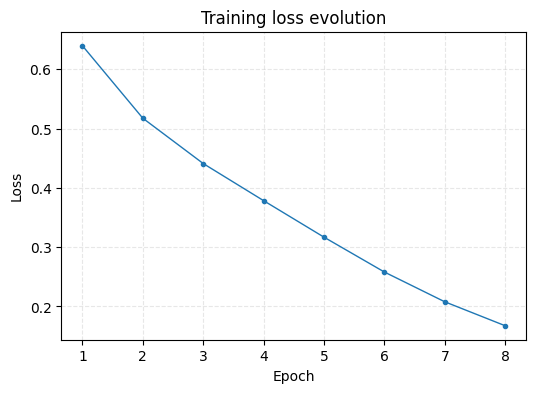

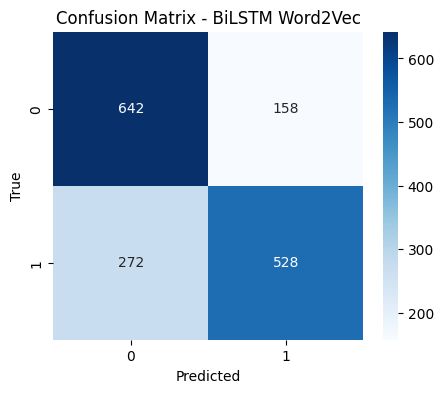

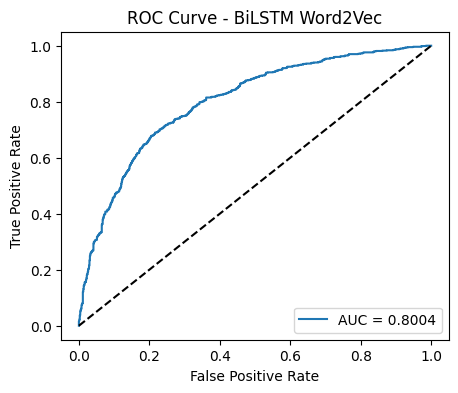

INFO:tensorflow:Assets written to: bilstm_w2v_model_package/saved_model/assets


INFO:tensorflow:Assets written to: bilstm_w2v_model_package/saved_model/assets


Saved artifact at 'bilstm_w2v_model_package/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 80), dtype=tf.float32, name='keras_tensor_8')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140189685375296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140189684949840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140189683536240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140189683540288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140189683539232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140189683542224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140189683545920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140189300156272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140189300160320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140189681454592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1

In [12]:
# from gensim.models import Word2Vec  # ou KeyedVectors selon ton fichier
from gensim.models import KeyedVectors
from sklearn.metrics import confusion_matrix, roc_curve, auc

# ---------- MLflow experiment ----------
mlflow.set_experiment("tweet_bilstm_w2v_optuna")

# charge le modèle w2v entraîné ailleurs
# W2V_PATH = "models/word2vec/word2vec_google_news_300.kv"  # adapte le chemin
# w2v_global = Word2Vec.load(W2V_PATH)
# EMBED_DIM_W2V = w2v_global.vector_size

W2V_PATH = "models/word2vec/word2vec_google_news_300.kv"
w2v_global = KeyedVectors.load(W2V_PATH, mmap='r')
EMBED_DIM_W2V = w2v_global.vector_size


def build_model_with_params(params, tokenizer, w2v, max_len=MAX_LEN):
    """
    Build BiLSTM model with fixed pre-trained Word2Vec embeddings.
    """
    embed_dim     = w2v.vector_size  # dimension imposée par le modèle pré-entraîné
    lstm_units    = params["lstm_units"]
    dense_units   = params["dense_units"]
    dropout_rate  = params["dropout_rate"]
    learning_rate = params["learning_rate"]
    trainable_emb = params["trainable_embedding"]

    num_words = tokenizer.num_words
    if num_words is None:
        num_words = min(VOCAB_SIZE, len(tokenizer.word_index) + 1)

    embedding_matrix = np.zeros((num_words, embed_dim), dtype="float32")

    for word, idx in tokenizer.word_index.items():
        if idx >= num_words:
            continue
        if word in w2v:
            vec = w2v[word]
            if vec.shape[0] == embed_dim:
                embedding_matrix[idx] = vec

    model = Sequential([
        Embedding(
            input_dim=num_words,
            output_dim=embed_dim,
            weights=[embedding_matrix],
            mask_zero=True,
            trainable=trainable_emb,
        ),
        Bidirectional(LSTM(lstm_units)),
        Dropout(dropout_rate),
        Dense(dense_units, activation="relu"),
        Dropout(dropout_rate),
        Dense(1, activation="sigmoid")
    ])

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model


def objective(trial):
    tf.keras.backend.clear_session()

    params = {
        "lstm_units": trial.suggest_int("lstm_units", 64, 256, step=64),
        "dense_units": trial.suggest_int("dense_units", 32, 128, step=32),
        "dropout_rate": trial.suggest_float("dropout_rate", 0.1, 0.5),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 5e-3, log=True),
        "trainable_embedding": trial.suggest_categorical("trainable_embedding", [False, True]),
        "batch_size": trial.suggest_categorical("batch_size", [32, 64, 128]),
        "epochs": trial.suggest_int("epochs", 3, 8),
    }

    with mlflow.start_run(run_name=f"trial_{trial.number}", nested=True):
        mlflow.log_params(params)

        tok = build_tokenizer(X_train, vocab_size=VOCAB_SIZE, oov_token="<OOV>")

        X_train_pad, _ = preprocess_train(X_train, tokenizer=tok, max_len=MAX_LEN)
        X_val_pad,   _ = preprocess_test(X_val, tokenizer=tok, max_len=MAX_LEN)

        # on utilise uniquement le modèle w2v_global déjà chargé
        model = build_model_with_params(params, tokenizer=tok, w2v=w2v_global, max_len=MAX_LEN)

        train_ds = tf.data.Dataset.from_tensor_slices((X_train_pad, y_train)).shuffle(10000).batch(params["batch_size"])
        val_ds   = tf.data.Dataset.from_tensor_slices((X_val_pad, y_val)).batch(params["batch_size"])

        history = model.fit(train_ds, validation_data=val_ds, epochs=params["epochs"], verbose=0)

        y_pred_prob = model.predict(X_val_pad, verbose=0).ravel()
        y_pred = (y_pred_prob >= 0.5).astype("int32")

        acc = accuracy_score(y_val, y_pred)
        prec, rec, f1, _ = precision_recall_fscore_support(y_val, y_pred, average="binary", zero_division=0)

        mlflow.log_metric("val_accuracy", acc)
        mlflow.log_metric("val_precision", prec)
        mlflow.log_metric("val_recall", rec)
        mlflow.log_metric("val_f1", f1)

        return f1


class ValMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_val, y_val):
        self.X_val = X_val
        self.y_val = y_val

    def on_epoch_end(self, epoch, logs=None):
        y_pred_prob = self.model.predict(self.X_val, verbose=0).ravel()
        y_pred = (y_pred_prob >= 0.5).astype("int32")

        acc = accuracy_score(self.y_val, y_pred)
        prec, rec, f1, _ = precision_recall_fscore_support(self.y_val, y_pred, average="binary", zero_division=0)

        mlflow.log_metric("val_accuracy_trace", acc, step=epoch)
        mlflow.log_metric("val_precision_trace", prec, step=epoch)
        mlflow.log_metric("val_recall_trace", rec, step=epoch)
        mlflow.log_metric("val_f1_trace", f1, step=epoch)

with mlflow.start_run(run_name="optuna_bilstm_w2v_parent"):

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=4)

    # ---- Optuna visualizations as artifacts ----
    try:
        import plotly  # noqa: F401
        fig1 = optuna.visualization.plot_optimization_history(study)
        mlflow.log_figure(fig1, "optimization_history_bilstm_w2v.html")
        fig2 = optuna.visualization.plot_param_importances(study)
        mlflow.log_figure(fig2, "param_importance_bilstm_w2v.html")
    except ImportError:
        print("⚠️ Plotly non installé — visualisations sautées.")

    best_trial = study.best_trial
    best_params = best_trial.params

    print("Best val F1:", best_trial.value)
    print("Best params:", best_params)

    mlflow.log_metric("best_val_f1", best_trial.value)
    mlflow.log_params({f"best_{k}": v for k, v in best_params.items()})

    X_train_full = X_train + X_val
    y_train_full = np.concatenate([y_train, y_val])

    tok_full_w2v = build_tokenizer(X_train_full, vocab_size=VOCAB_SIZE, oov_token="<OOV>")

    X_train_full_pad, _ = preprocess_train(X_train_full, tokenizer=tok_full_w2v, max_len=MAX_LEN)
    X_test_pad,       _ = preprocess_test(X_test, tokenizer=tok_full_w2v, max_len=MAX_LEN)

    model_best_w2v = build_model_with_params(best_params, tokenizer=tok_full_w2v, w2v=w2v_global)

    cb = ValMetricsCallback(X_val=X_test_pad, y_val=y_test)

    train_full_ds = tf.data.Dataset.from_tensor_slices((X_train_full_pad, y_train_full)).shuffle(10000).batch(best_params["batch_size"])

    history_w2v = model_best_w2v.fit(train_full_ds, epochs=best_params["epochs"], callbacks=[cb], verbose=0)

    y_test_pred_prob = model_best_w2v.predict(X_test_pad).ravel()
    y_test_pred = (y_test_pred_prob >= 0.5).astype("int32")

    test_acc = accuracy_score(y_test, y_test_pred)
    test_prec, test_rec, test_f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average="binary")

    mlflow.log_metric("test_accuracy", test_acc)
    mlflow.log_metric("test_precision", test_prec)
    mlflow.log_metric("test_recall", test_rec)
    mlflow.log_metric("test_f1", test_f1)

    # ---- Confusion Matrix (Test) ----
    cm = confusion_matrix(y_test, y_test_pred)
    fig_cm, ax_cm = plt.subplots(figsize=(4, 4))
    im = ax_cm.imshow(cm, interpolation="nearest", cmap="Blues")
    ax_cm.figure.colorbar(im, ax=ax_cm)
    ax_cm.set(
        xticks=[0, 1],
        yticks=[0, 1],
        xticklabels=["Prédit négatif", "Prédit positif"],
        yticklabels=["Réel négatif", "Réel positif"],
        ylabel="Réel",
        xlabel="Prédit",
        title="Matrice de confusion - BiLSTM Word2Vec"
    )
    labels = [["TN", "FP"], ["FN", "TP"]]
    for i in range(2):
        for j in range(2):
            ax_cm.text(j, i, f"{labels[i][j]} = {cm[i, j]}", ha="center", va="center", color="black")
    fig_cm.tight_layout()
    mlflow.log_figure(fig_cm, "confusion_matrix_bilstm_w2v.png")
    plt.close(fig_cm)

    # ---- ROC Curve (Test) ----
    fpr, tpr, _ = roc_curve(y_test, y_test_pred_prob)
    auc_score = auc(fpr, tpr)

    fig_auc, ax_auc = plt.subplots(figsize=(4, 4))
    ax_auc.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
    ax_auc.plot([0, 1], [0, 1], "k--", label="Aléatoire")
    ax_auc.set_xlabel("False Positive Rate")
    ax_auc.set_ylabel("True Positive Rate")
    ax_auc.set_title("Courbe ROC - BiLSTM Word2Vec")
    ax_auc.legend(loc="lower right")
    fig_auc.tight_layout()
    mlflow.log_figure(fig_auc, "roc_curve_bilstm_w2v.png")
    plt.close(fig_auc)

    # ---- Log AUC as model metric ----
    mlflow.log_metric("test_auc", auc_score)

    # ---- Log Model Artifact ----
    input_example = X_test_pad[:1]
    mlflow.tensorflow.log_model(
        model=model_best_w2v,
        artifact_path="best_model_bilstm_w2v",
        input_example=input_example,
    )

        # ---- Local artifacts (figures + model package) ----
    loss_fig, loss_df = create_training_loss_figure(history_w2v.history.get("loss", []))
    if loss_fig is not None:
        log_and_display_figure(loss_fig, "training_loss.png", artifact_dir=EVALUATION_ARTIFACT_SUBDIR_W2V)
        if loss_df is not None and not loss_df.empty:
            local_eval_dir = LOCAL_ARTIFACTS_DIR / EVALUATION_ARTIFACT_SUBDIR_W2V
            local_eval_dir.mkdir(parents=True, exist_ok=True)
            loss_df.to_csv(local_eval_dir / "training_loss.csv", index=False)
            mlflow.log_artifact(str(local_eval_dir / "training_loss.csv"), artifact_path=EVALUATION_ARTIFACT_SUBDIR_W2V)
            for _, row in loss_df.iterrows():
                mlflow.log_metric("training_loss_progress_w2v", row["loss"], step=int(row["epoch"]))

    fig_cm_local = create_confusion_matrix_figure(y_test, y_test_pred, title="Confusion Matrix - BiLSTM Word2Vec")
    log_and_display_figure(fig_cm_local, "confusion_matrix.png", artifact_dir=EVALUATION_ARTIFACT_SUBDIR_W2V)

    fig_roc_local, auc_local = create_roc_curve_figure(y_test, y_test_pred_prob, title="ROC Curve - BiLSTM Word2Vec")
    log_and_display_figure(fig_roc_local, "roc_curve.png", artifact_dir=EVALUATION_ARTIFACT_SUBDIR_W2V)

    inference_texts_w2v = ["I love how friendly this app is!"]
    inference_tokens_w2v, _ = preprocess_test(inference_texts_w2v, tok_full_w2v, MAX_LEN)
    save_and_log_model_artifacts(
        model_best_w2v,
        tok_full_w2v,
        MODEL_ARTIFACT_DIR_W2V,
        embedding_info={"type": "word2vec", "path": W2V_PATH, "dim": EMBED_DIM_W2V, "trainable": best_params.get("trainable_embedding")},
        input_example_tokens=inference_tokens_w2v,
        input_example_texts=inference_texts_w2v,
        artifact_path="model_package_bilstm_w2v",
    )


In [13]:
model_best_w2v.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 80, 300)        │     6,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       439,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 96)             │        24,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,392,197 (73.98 MB)

 Trainable params: 6,464,065 (24.66 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,928,132 (49.32 MB)

## Griding optuna + Glove

[I 2025-12-02 11:17:43,145] A new study created in memory with name: no-name-f689fdcb-f671-4e14-8552-24c2d7273c0c


Loaded 1193514 GloVe word vectors.


/home/kamel/Openclassroom_projets/P7/.p7venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning:

Argument `input_length` is deprecated. Just remove it.

[I 2025-12-02 11:18:16,417] Trial 0 finished with value: 0.7468277945619335 and parameters: {'embed_dim': 100, 'lstm_units': 128, 'dense_units': 96, 'dropout_rate': 0.21508341490628863, 'learning_rate': 0.0011259462998133459, 'trainable_embedding': False, 'batch_size': 128, 'epochs': 8}. Best is trial 0 with value: 0.7468277945619335.


Loaded 1193514 GloVe word vectors.


/home/kamel/Openclassroom_projets/P7/.p7venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning:

Argument `input_length` is deprecated. Just remove it.

[I 2025-12-02 11:19:05,638] Trial 1 finished with value: 0.7550505050505051 and parameters: {'embed_dim': 100, 'lstm_units': 192, 'dense_units': 64, 'dropout_rate': 0.1089702335011082, 'learning_rate': 0.0003561806304555426, 'trainable_embedding': True, 'batch_size': 32, 'epochs': 5}. Best is trial 1 with value: 0.7550505050505051.


Loaded 1193514 GloVe word vectors.


/home/kamel/Openclassroom_projets/P7/.p7venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning:

Argument `input_length` is deprecated. Just remove it.

[I 2025-12-02 11:20:04,903] Trial 2 finished with value: 0.7345187001839363 and parameters: {'embed_dim': 100, 'lstm_units': 128, 'dense_units': 64, 'dropout_rate': 0.37456703706493344, 'learning_rate': 0.0017469573737618524, 'trainable_embedding': True, 'batch_size': 32, 'epochs': 7}. Best is trial 1 with value: 0.7550505050505051.


Loaded 1193514 GloVe word vectors.


/home/kamel/Openclassroom_projets/P7/.p7venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning:

Argument `input_length` is deprecated. Just remove it.

[I 2025-12-02 11:20:26,760] Trial 3 finished with value: 0.7562814070351759 and parameters: {'embed_dim': 50, 'lstm_units': 64, 'dense_units': 128, 'dropout_rate': 0.15502880123563734, 'learning_rate': 0.00023339739067364015, 'trainable_embedding': True, 'batch_size': 128, 'epochs': 7}. Best is trial 3 with value: 0.7562814070351759.


Best params: {'embed_dim': 50, 'lstm_units': 64, 'dense_units': 128, 'dropout_rate': 0.15502880123563734, 'learning_rate': 0.00023339739067364015, 'trainable_embedding': True, 'batch_size': 128, 'epochs': 7}
Best val F1: 0.7562814070351759
Loaded 1193514 GloVe word vectors.


/home/kamel/Openclassroom_projets/P7/.p7venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning:

Argument `input_length` is deprecated. Just remove it.



50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


2025/12/02 11:20:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step

Final Test results:
Accuracy: 0.748125
Precision: 0.7581274382314694
Recall: 0.72875
F1: 0.7431485022307202


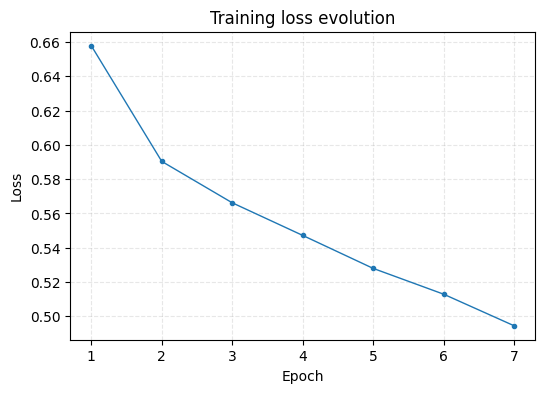

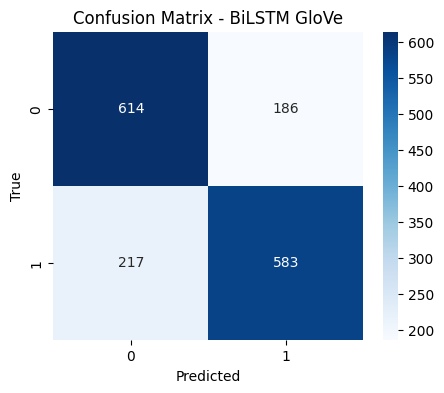

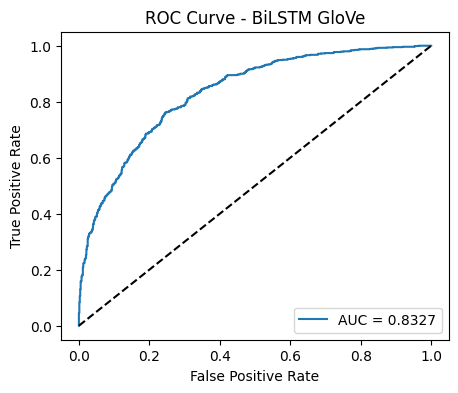

INFO:tensorflow:Assets written to: bilstm_glove_model_package/saved_model/assets


INFO:tensorflow:Assets written to: bilstm_glove_model_package/saved_model/assets


Saved artifact at 'bilstm_glove_model_package/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 50), dtype=tf.float32, name='keras_tensor_8')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140189297786576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140187423845264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140187675766704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140187423847376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140187675768640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140187682715104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140187675769344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140187582129328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140187582125456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140187582130912: TensorSpec(shape=(), dtype=tf.resource, name=None)
 

In [14]:
# =============================================================================
# IMPORTS
# =============================================================================
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import mlflow
import mlflow.tensorflow
import optuna

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

# =============================================================================
# PREPROCESSING (your existing functions)
# =============================================================================

# (I keep your normalization as-is, not repeated here to save space)
# Paste your normalize_tweet(), build_tokenizer(),
# preprocess_train(), preprocess_test() functions here.
mlflow.set_experiment("tweet_bilstm_w2v_optuna")

# =============================================================================
# LOAD GLOVE EMBEDDINGS
# =============================================================================

def load_glove_embeddings(glove_path):
    '''
    Load pre-trained GloVe word embeddings from a text file.

    The file is expected to have one word vector per line, with the format:
    <word> <dim_1> <dim_2> ... <dim_N>
    '''
    embeddings = {}
    with open(glove_path, "r", encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype="float32")
            embeddings[word] = vector

    print(f"Loaded {len(embeddings)} GloVe word vectors.")
    return embeddings


def build_glove_embedding_matrix(tokenizer, glove_vectors, embed_dim, vocab_size):
    '''
    Build an embedding weight matrix aligned with a Keras Tokenizer vocabulary,
    using pre-trained GloVe word vectors.

    Each row i of the returned matrix corresponds to the embedding for the word
    whose index is i in `tokenizer.word_index` (up to `vocab_size`). Words that
    are not found in `glove_vectors` remain as zero vectors.
    '''
    num_words = min(vocab_size, len(tokenizer.word_index) + 1)
    embedding_matrix = np.zeros((num_words, embed_dim), dtype="float32")

    for word, idx in tokenizer.word_index.items():
        if idx >= num_words:
            continue
        vec = glove_vectors.get(word)
        if vec is not None:
            embedding_matrix[idx] = vec

    return embedding_matrix


# =============================================================================
# MODEL BUILDER (uses GloVe embedding matrix)
# =============================================================================

def build_model_with_params(params, tokenizer, embedding_matrix, max_len, vocab_size):

    model = Sequential([
        Embedding(
            input_dim=min(vocab_size, len(tokenizer.word_index) + 1),
            output_dim=params["embed_dim"],
            weights=[embedding_matrix],
            input_length=max_len,
            mask_zero=True,
            trainable=params["trainable_embedding"]
        ),
        SpatialDropout1D(params["dropout_rate"]),
        Bidirectional(LSTM(params["lstm_units"], return_sequences=False)),
        Dense(params["dense_units"], activation="relu"),
        Dropout(params["dropout_rate"]),
        Dense(1, activation="sigmoid")
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(params["learning_rate"]),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model


# =============================================================================
# CALLBACK FOR VAL METRIC TRACES (parent run)
# =============================================================================

class ValMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_val, y_val):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val

    def on_epoch_end(self, epoch, logs=None):
        y_pred_prob = self.model.predict(self.X_val, verbose=0).ravel()
        y_pred = (y_pred_prob >= 0.5).astype("int32")

        acc = accuracy_score(self.y_val, y_pred)
        prec, rec, f1, _ = precision_recall_fscore_support(
            self.y_val, y_pred, average="binary", zero_division=0
        )

        mlflow.log_metric("val_accuracy_trace", acc, step=epoch)
        mlflow.log_metric("val_precision_trace", prec, step=epoch)
        mlflow.log_metric("val_recall_trace", rec, step=epoch)
        mlflow.log_metric("val_f1_trace", f1, step=epoch)


# =============================================================================
# OPTUNA OBJECTIVE (child runs)
# =============================================================================

VOCAB_SIZE = 20000
MAX_LEN = 50

def objective(trial):

    tf.keras.backend.clear_session()

    # ---- Optuna Hyperparameters ----
    params = {
        "embed_dim": trial.suggest_categorical("embed_dim", [50, 100, 200]),
        "lstm_units": trial.suggest_int("lstm_units", 64, 256, step=64),
        "dense_units": trial.suggest_int("dense_units", 32, 128, step=32),
        "dropout_rate": trial.suggest_float("dropout_rate", 0.1, 0.5),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 5e-3, log=True),
        "trainable_embedding": trial.suggest_categorical("trainable_embedding", [False, True]),
        "batch_size": trial.suggest_categorical("batch_size", [32, 64, 128]),
        "epochs": trial.suggest_int("epochs", 3, 8),
    }

    # ---- Child MLflow Run ----
    with mlflow.start_run(run_name=f"trial_{trial.number}", nested=True):
        mlflow.log_params(params)

        # ---- Tokenizer ----
        tok = build_tokenizer(X_train, VOCAB_SIZE, "<OOV>")

        # ---- Load GloVe ----
        glove_path = f"models/glove/embeddings/glove.twitter.27B.{params['embed_dim']}d.txt"
        glove_vectors = load_glove_embeddings(glove_path)

        # ---- Embedding Matrix ----
        embedding_matrix = build_glove_embedding_matrix(tok, glove_vectors,
                                                        params["embed_dim"], VOCAB_SIZE)

        # ---- Sequences ----
        X_train_pad, _ = preprocess_train(X_train, tok, MAX_LEN)
        X_val_pad, _ = preprocess_test(X_val, tok, MAX_LEN)

        # ---- Model ----
        model = build_model_with_params(params, tok, embedding_matrix, MAX_LEN, VOCAB_SIZE)

        # ---- Datasets ----
        train_ds = tf.data.Dataset.from_tensor_slices((X_train_pad, y_train)) \
            .shuffle(10000).batch(params["batch_size"])
        val_ds = tf.data.Dataset.from_tensor_slices((X_val_pad, y_val)) \
            .batch(params["batch_size"])

        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=params["epochs"],
            verbose=0
        )

        # ---- Validation Predictions ----
        y_pred_prob = model.predict(X_val_pad, verbose=0).ravel()
        y_pred = (y_pred_prob >= 0.5).astype("int32")

        acc = accuracy_score(y_val, y_pred)
        prec, rec, f1, _ = precision_recall_fscore_support(y_val, y_pred,
                                                           average="binary", zero_division=0)

        mlflow.log_metric("val_accuracy", acc)
        mlflow.log_metric("val_precision", prec)
        mlflow.log_metric("val_recall", rec)
        mlflow.log_metric("val_f1", f1)

        return f1  # maximize val F1


# =============================================================================
# RUN OPTUNA + PARENT MLFLOW LOGGING
# =============================================================================



# =============================================================================
# PARENT RUN FINAL MODEL (train on train+val, test on test)
# =============================================================================

with mlflow.start_run(run_name="optuna_bilstm_GloVe_parent"):

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=4)

    # ---- Optuna visualizations as artifacts ----
    try:
        import plotly  # noqa: F401
        fig1 = optuna.visualization.plot_optimization_history(study)
        mlflow.log_figure(fig1, "optimization_history_bilstm_glove.html")
        fig2 = optuna.visualization.plot_param_importances(study)
        mlflow.log_figure(fig2, "param_importance_bilstm_glove.html")
    except ImportError:
        print("⚠️ Plotly non installé — visualisations sautées.")

    print("Best params:", study.best_trial.params)
    print("Best val F1:", study.best_trial.value)
    best_params = study.best_trial.params
    mlflow.log_metric("best_val_f1", study.best_trial.value)
    mlflow.log_params({f"best_{k}": v for k, v in best_params.items()})

    # ---- Combine Train + Val ----
    X_train_full = X_train + X_val
    y_train_full = np.concatenate([y_train, y_val])

    # ---- Tokenizer ----
    tok_full_glove = build_tokenizer(X_train_full, VOCAB_SIZE, "<OOV>")

    # ---- Load GloVe ----
    glove_path = f"models/glove/embeddings/glove.twitter.27B.{best_params['embed_dim']}d.txt"
    glove_vectors = load_glove_embeddings(glove_path)

    # ---- Embedding Matrix ----
    embedding_matrix_full = build_glove_embedding_matrix(tok_full_glove, glove_vectors,
                                                         best_params["embed_dim"], VOCAB_SIZE)

    # ---- Sequences ----
    X_train_full_pad, _ = preprocess_train(X_train_full, tok_full_glove, MAX_LEN)
    X_test_pad, _ = preprocess_test(X_test, tok_full_glove, MAX_LEN)

    # ---- Final Model ----
    model_best_glove = build_model_with_params(best_params, tok_full_glove,
                                         embedding_matrix_full, MAX_LEN, VOCAB_SIZE)

    # ---- Callback (Validation Trace on Test Set) ----
    cb = ValMetricsCallback(X_test_pad, y_test)

    train_full_ds = tf.data.Dataset.from_tensor_slices((X_train_full_pad, y_train_full)) \
        .shuffle(10000).batch(best_params["batch_size"])

    history_glove = model_best_glove.fit(train_full_ds, epochs=best_params["epochs"],
                   callbacks=[cb], verbose=0)

    # ---- Test Metrics ----
    y_pred_prob = model_best_glove.predict(X_test_pad).ravel()
    y_pred = (y_pred_prob >= 0.5).astype("int32")

    test_acc = accuracy_score(y_test, y_pred)
    test_prec, test_rec, test_f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="binary", zero_division=0
    )

    mlflow.log_metric("test_accuracy", test_acc)
    mlflow.log_metric("test_precision", test_prec)
    mlflow.log_metric("test_recall", test_rec)
    mlflow.log_metric("test_f1", test_f1)

    # ---- Confusion Matrix (Test) ----
    cm = confusion_matrix(y_test, y_pred)
    fig_cm, ax_cm = plt.subplots(figsize=(4, 4))
    im = ax_cm.imshow(cm, interpolation="nearest", cmap="Blues")
    ax_cm.figure.colorbar(im, ax=ax_cm)
    ax_cm.set(
        xticks=[0, 1],
        yticks=[0, 1],
        xticklabels=["Prédit négatif", "Prédit positif"],
        yticklabels=["Réel négatif", "Réel positif"],
        ylabel="Réel",
        xlabel="Prédit",
        title="Matrice de confusion - BiLSTM GloVe"
    )
    labels = [["TN", "FP"], ["FN", "TP"]]
    for i in range(2):
        for j in range(2):
            ax_cm.text(j, i, f"{labels[i][j]} = {cm[i, j]}",
                       ha="center", va="center", color="black")
    fig_cm.tight_layout()
    mlflow.log_figure(fig_cm, "confusion_matrix_bilstm_glove.png")
    plt.close(fig_cm)

    # ---- ROC Curve (Test) ----
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    auc_score = auc(fpr, tpr)

    fig_auc, ax_auc = plt.subplots(figsize=(4, 4))
    ax_auc.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
    ax_auc.plot([0, 1], [0, 1], "k--", label="Aléatoire")
    ax_auc.set_xlabel("False Positive Rate")
    ax_auc.set_ylabel("True Positive Rate")
    ax_auc.set_title("Courbe ROC - BiLSTM GloVe")
    ax_auc.legend(loc="lower right")
    fig_auc.tight_layout()
    mlflow.log_figure(fig_auc, "roc_curve_bilstm_glove.png")
    plt.close(fig_auc)

    # ---- Log AUC as model metric ----
    mlflow.log_metric("test_auc", auc_score)

    # ---- Log Model Artifact ----
    input_example = X_test_pad[:1]
    mlflow.tensorflow.log_model(
        model=model_best_glove,
        artifact_path="best_model_bilstm_glove",
        input_example=input_example,
    )

    print("\nFinal Test results:")
    print("Accuracy:", test_acc)
    print("Precision:", test_prec)
    print("Recall:", test_rec)
    print("F1:", test_f1)

        # ---- Local artifacts (figures + model package) ----
    loss_fig, loss_df = create_training_loss_figure(history_glove.history.get("loss", []))
    if loss_fig is not None:
        log_and_display_figure(loss_fig, "training_loss.png", artifact_dir=EVALUATION_ARTIFACT_SUBDIR_GLOVE)
        if loss_df is not None and not loss_df.empty:
            local_eval_dir = LOCAL_ARTIFACTS_DIR / EVALUATION_ARTIFACT_SUBDIR_GLOVE
            local_eval_dir.mkdir(parents=True, exist_ok=True)
            loss_df.to_csv(local_eval_dir / "training_loss.csv", index=False)
            mlflow.log_artifact(str(local_eval_dir / "training_loss.csv"), artifact_path=EVALUATION_ARTIFACT_SUBDIR_GLOVE)
            for _, row in loss_df.iterrows():
                mlflow.log_metric("training_loss_progress_glove", row["loss"], step=int(row["epoch"]))

    fig_cm_local = create_confusion_matrix_figure(y_test, y_pred, title="Confusion Matrix - BiLSTM GloVe")
    log_and_display_figure(fig_cm_local, "confusion_matrix.png", artifact_dir=EVALUATION_ARTIFACT_SUBDIR_GLOVE)

    fig_roc_local, auc_local = create_roc_curve_figure(y_test, y_pred_prob, title="ROC Curve - BiLSTM GloVe")
    log_and_display_figure(fig_roc_local, "roc_curve.png", artifact_dir=EVALUATION_ARTIFACT_SUBDIR_GLOVE)

    inference_texts_glove = ["I love how friendly this app is!"]
    inference_tokens_glove, _ = preprocess_test(inference_texts_glove, tok_full_glove, MAX_LEN)
    save_and_log_model_artifacts(
        model_best_glove,
        tok_full_glove,
        MODEL_ARTIFACT_DIR_GLOVE,
        embedding_info={"type": "glove", "dim": best_params.get("embed_dim"), "trainable": best_params.get("trainable_embedding")},
        input_example_tokens=inference_tokens_glove,
        input_example_texts=inference_texts_glove,
        artifact_path="model_package_bilstm_glove",
    )


In [15]:
model_best_glove.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 50, 50)         │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 50, 50)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        58,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,226,565 (12.31 MB)

 Trainable params: 1,075,521 (4.10 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,151,044 (8.21 MB)

# Testing on hard tweets

In [16]:
# Testing on hard tweets for both BiLSTM variants

hard_tweets_dataset = [
    {"category": "sarcasme", "tweet": "Great job @AirParadis, another ‘on-time’ departure… only 3 hours late. Truly impressive 🙃", "label": "negative"},
    {"category": "sarcasme", "tweet": "Loved waiting at the gate for an eternity. Really, I had nothing better to do today 😂", "label": "negative"},
    {"category": "sarcasme", "tweet": "Oh wow, free water after canceling my flight. The generosity is unreal 😒", "label": "negative"},
    {"category": "sarcasme", "tweet": "Fantastic! My luggage is on holiday in Paris while I'm stuck here. Amazing service!", "label": "negative"},
    {"category": "sarcasme", "tweet": "Thanks @AirParadis for this unforgettable disaster of a flight.", "label": "negative"},
    {"category": "ambiguite", "tweet": "This flight felt terrible from start to finish.", "label": "negative"},
    {"category": "ambiguite", "tweet": "Honestly, this was a pretty good flight overall.", "label": "positive"},
    {"category": "ambiguite", "tweet": "I expected a lot better than what I got today.", "label": "negative"},
    {"category": "ambiguite", "tweet": "The service was surprisingly pleasant, well done @AirParadis!", "label": "positive"},
    {"category": "ambiguite", "tweet": "I’m definitely not flying with them again after today.", "label": "negative"},
    {"category": "double_neg", "tweet": "I can’t say the flight was bad — it was actually very good.", "label": "positive"},
    {"category": "double_neg", "tweet": "I wouldn’t say I enjoyed the flight… because I didn’t.", "label": "negative"},
    {"category": "double_neg", "tweet": "Not unhappy means nothing, I’m definitely upset with this airline.", "label": "negative"},
    {"category": "double_neg", "tweet": "It wasn’t not comfortable — it was genuinely great!", "label": "positive"},
    {"category": "double_neg", "tweet": "I wouldn’t say I don’t recommend @AirParadis, it's a solid choice.", "label": "positive"},
    {"category": "mixed_complex", "tweet": "The landing was smooth and the staff was incredibly kind. Great flight!", "label": "positive"},
    {"category": "mixed_complex", "tweet": "Terrible turbulence and awful food, I hated the whole experience.", "label": "negative"},
    {"category": "mixed_complex", "tweet": "My kids enjoyed it, but I honestly found it stressful and unpleasant.", "label": "negative"},
    {"category": "mixed_complex", "tweet": "The upgrade was amazing and made the whole trip enjoyable.", "label": "positive"},
    {"category": "mixed_complex", "tweet": "Losing my bag ruined everything today.", "label": "negative"},
    {"category": "pos_neg", "tweet": "The flight was long but honestly quite enjoyable.", "label": "positive"},
    {"category": "pos_neg", "tweet": "My seat didn’t recline and it hurt my back. Terrible comfort.", "label": "negative"},
    {"category": "pos_neg", "tweet": "The chaos was stressful and I didn’t enjoy this flight at all.", "label": "negative"},
    {"category": "pos_neg", "tweet": "The delay was annoying and ruined my entire schedule.", "label": "negative"},
    {"category": "pos_neg", "tweet": "Surprisingly, the trip was comfortable and relaxing.", "label": "positive"},
    {"category": "implicite", "tweet": "I don’t even have the energy to complain anymore.", "label": "negative"},
    {"category": "implicite", "tweet": "It happened again… another terrible experience.", "label": "negative"},
    {"category": "implicite", "tweet": "I’m not mad. I’m extremely disappointed.", "label": "negative"},
    {"category": "implicite", "tweet": "No words. Just a horrible flight.", "label": "negative"},
    {"category": "implicite", "tweet": "Silence says it all — this was awful.", "label": "negative"},
    {"category": "sarcasme_positif", "tweet": "Wow, @AirParadis took off on time. Miracles do happen!", "label": "positive"},
    {"category": "sarcasme_positif", "tweet": "Not getting bumped from my seat today? Incredible!", "label": "positive"},
    {"category": "sarcasme_positif", "tweet": "Flight attendants actually smiled. Impressive!", "label": "positive"},
    {"category": "sarcasme_positif", "tweet": "A full flight without any issues? Amazing!", "label": "positive"},
    {"category": "sarcasme_positif", "tweet": "The plane landed early… surprisingly good job.", "label": "positive"},
    {"category": "pos_surface_neg_fond", "tweet": "I’m ‘thrilled’ that my flight was delayed again. Awful service.", "label": "negative"},
    {"category": "pos_surface_neg_fond", "tweet": "Consistently disappointing, as always.", "label": "negative"},
    {"category": "pos_surface_neg_fond", "tweet": "The announcements were useless and the whole trip was terrible.", "label": "negative"},
    {"category": "pos_surface_neg_fond", "tweet": "Free snack but still not getting home today? Terrible airline.", "label": "negative"},
    {"category": "pos_surface_neg_fond", "tweet": "Great, another delay. This airline is exhausting.", "label": "negative"},
]

LABEL_MAP = {1: "positive", 0: "negative"}
VALID_EVAL_LABELS = {"positive", "negative"}


def evaluate_hard_dataset(name, model, tokenizer):
    texts = [row["tweet"] for row in hard_tweets_dataset]
    labels = [row["label"].lower() for row in hard_tweets_dataset]
    categories = [row["category"] for row in hard_tweets_dataset]

    seqs, _ = preprocess_test(texts, tokenizer, MAX_LEN)
    prob_pos = model.predict(seqs, verbose=0).ravel()
    preds = (prob_pos >= 0.5).astype(int)

    rows = []
    for raw_tweet, expected, cat, prob, pred in zip(texts, labels, categories, prob_pos, preds):
        predicted_label = LABEL_MAP[pred]
        score = float(prob if pred == 1 else 1 - prob)
        rows.append({
            "category": cat,
            "tweet": raw_tweet,
            "label_attendue": expected,
            "prediction": predicted_label,
            "score": round(score, 4),
            "ok": predicted_label == expected if expected in VALID_EVAL_LABELS else None,
        })

    df_res = pd.DataFrame(rows)
    display(df_res)

    filtered = df_res[df_res["label_attendue"].isin(VALID_EVAL_LABELS)]
    if not filtered.empty:
        global_acc = (filtered["label_attendue"] == filtered["prediction"]).mean()
        print(f"🎯 {name} - Accuracy globale (pos/neg) : {global_acc:.4f}")
        print("📊 Accuracy par catégorie :")
        cat_acc = filtered.groupby("category").apply(lambda g: (g["label_attendue"] == g["prediction"]).mean())
        display(cat_acc)


if 'model_best_w2v' in globals():
    evaluate_hard_dataset("BiLSTM Word2Vec", model_best_w2v, tok_full_w2v)

if 'model_best_glove' in globals():
    evaluate_hard_dataset("BiLSTM GloVe", model_best_glove, tok_full_glove)


,category,tweet,label_attendue,prediction,score,ok
0,sarcasme,"Great job @AirParadis, another ‘on-time’ depar...",negative,negative,0.6957,True
1,sarcasme,Loved waiting at the gate for an eternity. Rea...,negative,negative,0.9983,True
2,sarcasme,"Oh wow, free water after canceling my flight. ...",negative,negative,0.9946,True
3,sarcasme,Fantastic! My luggage is on holiday in Paris w...,negative,negative,0.9830,True
4,sarcasme,Thanks @AirParadis for this unforgettable disa...,negative,positive,0.9401,False
5,ambiguite,This flight felt terrible from start to finish.,negative,negative,0.9973,True
6,ambiguite,"Honestly, this was a pretty good flight overall.",positive,positive,0.6379,True
7,ambiguite,I expected a lot better than what I got today.,negative,positive,0.8097,False
8,ambiguite,"The service was surprisingly pleasant, well do...",positive,positive,0.9948,True
9,ambiguite,I’m definitely not flying with them again afte...,negative,negative,0.5367,True


🎯 BiLSTM Word2Vec - Accuracy globale (pos/neg) : 0.7000
📊 Accuracy par catégorie :


category
ambiguite               0.8
double_neg              0.4
implicite               1.0
mixed_complex           0.8
pos_neg                 0.8
pos_surface_neg_fond    0.6
sarcasme                0.8
sarcasme_positif        0.4
dtype: float64

,category,tweet,label_attendue,prediction,score,ok
0,sarcasme,"Great job @AirParadis, another ‘on-time’ depar...",negative,positive,0.8060,False
1,sarcasme,Loved waiting at the gate for an eternity. Rea...,negative,negative,0.7359,True
2,sarcasme,"Oh wow, free water after canceling my flight. ...",negative,negative,0.7126,True
3,sarcasme,Fantastic! My luggage is on holiday in Paris w...,negative,positive,0.5070,False
4,sarcasme,Thanks @AirParadis for this unforgettable disa...,negative,positive,0.9316,False
5,ambiguite,This flight felt terrible from start to finish.,negative,negative,0.9349,True
6,ambiguite,"Honestly, this was a pretty good flight overall.",positive,positive,0.6481,True
7,ambiguite,I expected a lot better than what I got today.,negative,negative,0.6820,True
8,ambiguite,"The service was surprisingly pleasant, well do...",positive,positive,0.8409,True
9,ambiguite,I’m definitely not flying with them again afte...,negative,negative,0.8065,True


🎯 BiLSTM GloVe - Accuracy globale (pos/neg) : 0.7250
📊 Accuracy par catégorie :


category
ambiguite               1.0
double_neg              0.6
implicite               1.0
mixed_complex           1.0
pos_neg                 0.8
pos_surface_neg_fond    0.6
sarcasme                0.4
sarcasme_positif        0.4
dtype: float64

# End